In [1]:
import re
import glob
import numpy as np         
import tensorflow as tf    
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

glob모듈이 파일을 읽어오는 작업을 하기 유용하니까 사용하자.
작사가 인공지능 만들기는 결국 텍스트 데이터를 사용하는거니까
텍스트파일을 가져오자.

In [2]:
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


텍스트 파일들을 모두 읽어서 raw_corpus에 담는 작업을 한다
데이터의 크기는 총 187088개다
예시의 문장들을 3개 가져와보면 위에 문장이 나온다.

In [3]:
for idx, sentence in enumerate(raw_corpus):
    # 길이가 0이면 패스
    if len(sentence) == 0: continue
    # 문장의 끝이 :이면 패스
    if sentence[-1] == ":": continue 
    #10개 문장만 먼저 보겠습니다.
    if idx >9: break 
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof


raw_corpus에 담겨있는 텍스트파일을 가져오자
문장 끝이 :이면 건너뛰는 기호이기 때문에 
다음문장을 가져오는거 같다.
그래서 10개 문장을 가져오면 10줄 문장이 나온다.

In [4]:
def preprocess_sentence(sentence):
    #일단 모두 소문자로 변환하고 양쪽 공백을 지웁니다.
    sentence = sentence.lower().strip()   
    # 아래 특수문자 기호 양쪽에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
     # 공백이 많을 수 있는 부분에는 하나의 공백으로 통일합니다.
    sentence = re.sub(r'[" "]+', " ", sentence) 
     # ""안에 들어가있는 기호들 외에 공백으로 바꿉니다.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    #다시 양쪽 공백을 지웁니다.
    sentence = sentence.strip()
    # 문장 시작과 끝에 start와 end 를 추가합니다.
    sentence = '<start> ' + sentence + ' <end>'     
    
    return sentence

# 아래 같이 결측치 투성이인 문장이 어떻게 변하는지 확인합니다.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


특수문자와 공백을 제거해서 우리가 원하는 데이터만 추출해본다음
문장의 시작과 끝의 정보를 넣어주면 위에 결과처럼 스타트, 앤드가 나온다

In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

특수문자가 제거되었다 

In [6]:
def tokenize(corpus):
    # 텐서플로의 토크마이저를 이용해서 12000개 단어 개수를 숫자로 바꿔줍니다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 전체 단어의 개수 
        num_words=12000,  
        #이 함수에서 제공하는 문장 전처리 (하지만 우린 이미 진행해서 사용안함)
        filters=' ',   
        #12000단어에 속하지 않으면 unk로 바꿔숩니다.
        oov_token="<unk>" 
    )
    #위에서 만든 문장을 토크마이저에 넣어 데이터를 구축합니다.
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus) 
	
    #문장의 길이를 맞추고 숫자로 반환하기 위해 작업을 합니다.
    # 문장의 길이는 가장 긴 문장을 기준으로 pandding합니다.
    #여기서 maxien을 설정해 주었는데 이상치에 대응하기 할 수 있다고 합니다.
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    5 ...    0    0    0]
 [   2   17 2639 ...    0    0    0]
 [   2   36    7 ...    0    0    0]
 ...
 [   2  130    5 ...    0    0    0]
 [ 287   79  162 ...  877  647    3]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fcfb1e81640>


다음으로 데이터를 토큰화 시켜주는 작업을 시켜주는데 여기서 단어장 크기 12000개로 하라고 했으니 설정한다.
이건 문장을 쪼개서 기계가 이해할 수 있는 벡터로 변환시켜주는 과정이라고 한다.
여기서 평균 길이보다 큰 outlier가 있을 수 있으므로 maxlen을 설정해 제거해준다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx > 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it


토큰화시키니까 이렇게 나온다.

In [8]:
#마지막 토큰을 잘라냅니다. 위에서 end라고 설정했지만 문장 길이 상 pad인 것이 많을 것입니다.
src_input = tensor[:, :-1]
#앞에 start부분을 자릅니다. 
tgt_input = tensor[:, 1:]
print(src_input[0])
print(tgt_input[0])

[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0
    0    0    0    0    0]
[  50    5   91  297   65   57    9  969 6042    3    0    0    0    0
    0    0    0    0    0]


길이를 20으로 맞추고 나머지 빈칸 부분을 0으로 한다.
가로 칸에 갯수를 세 보면 19개다.

In [9]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

여기서 훈련 데이터 셋이랑 테스터 데이터 셋을 분리시켜준다

In [10]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [11]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
#문장을 토큰으로 했을 때 19이므로 19로 구성했습니다.
embedding_size = 19
hidden_size = 2048

#여기서 tokenizer.num_words + 1를 했는데 그 이유는 문장에 없는 pad 가 넣어졌기 때문입니다.
#문장길이를 모두 통일 하기 위해 가장 긴문장 말고는 모든 토큰이 0으로 들어간 부분 때문입니다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)
model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
550/550 [==============================] - 385s 664ms/step - loss: 3.2136 - val_loss: 2.8382
Epoch 2/10
550/550 [==============================] - 371s 674ms/step - loss: 2.7136 - val_loss: 2.6180
Epoch 3/10
550/550 [==============================] - 374s 680ms/step - loss: 2.5330 - val_loss: 2.4800
Epoch 4/10
550/550 [==============================] - 375s 682ms/step - loss: 2.3908 - val_loss: 2.3669
Epoch 5/10
550/550 [==============================] - 376s 683ms/step - loss: 2.2592 - val_loss: 2.2767
Epoch 6/10
550/550 [==============================] - 375s 683ms/step - loss: 2.1362 - val_loss: 2.2063
Epoch 7/10
550/550 [==============================] - 376s 684ms/step - loss: 2.0183 - val_loss: 2.1478
Epoch 8/10
550/550 [==============================] - 376s 684ms/step - loss: 1.9023 - val_loss: 2.0932
Epoch 9/10
550/550 [==============================] - 377s 685ms/step - loss: 1.7858 - val_loss: 2.0482
Epoch 10/10
550/550 [==============================] - 376s 685m

그리고 테스트를 하기 위해 테스트 생성 모델을 정의해주고
학습을 10번 시켜보았다.
너무 오래걸린다. 그래도 손실이 2.0133까지 떨어졌다.

In [13]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  228019    
_________________________________________________________________
lstm (LSTM)                  multiple                  16941056  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 75,321,748
Trainable params: 75,321,748
Non-trainable params: 0
_________________________________________________________________


위에 구축한 모델 summary를 한번 확인해보기 위해 데이터 한개를 model에 넣어 summary를
확인해봤다.
백만이라서 학습이 오래걸렸나?
한개당 5분 잡아서 총 50분동안 학습시켰는데

In [14]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    return generated

그래서 위에서 학습한 결과를 가지고 어떤 문장이 나오는지 한번 확인해 봐야겠다
"i love"로 시작해서 최대 20칸 안에 어떤 문장이 나올까?


In [15]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [16]:
import matplotlib.pyplot as plt
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

학습한 수에 따른 손실률 변화에 대한 그래프를 보고 싶을 때


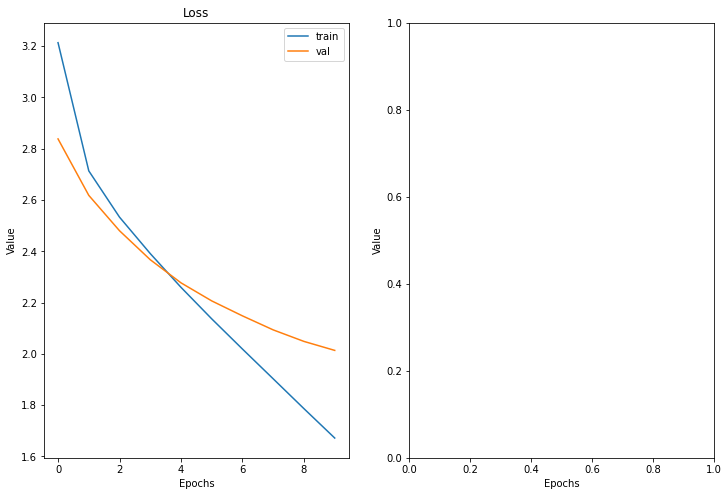

In [17]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

여기까지 혼자서 해봤는데 정말 어려웠다..
인터넷 찾아보면서 했는데 왜 저 학습 손실은 2에서 떨어지지 않을까..?
근데 학습량이 많아서 그런지 너무 느려서 더 늘리지 못하겠다...
아니면 내가 잘못된건가..?
물어보고 싶은데 뭐부터 물어봐야 될지 모르겠당.